In [44]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk

In [45]:
# Função para calcular as Bandas de Bollinger
def bollinger_bands(df, n=20, n_std=2):
    df['SMA'] = df['Close'].rolling(window=n).mean()
    df['STD'] = df['Close'].rolling(window=n).std()
    df['Upper Band'] = df['SMA'] + (n_std * df['STD'])
    df['Lower Band'] = df['SMA'] - (n_std * df['STD'])
    return df

# Função para calcular o Estocástico Lento
def stochastic(df, k_window=14, d_window=3):
    df['L14'] = df['Low'].rolling(window=k_window).min()
    df['H14'] = df['High'].rolling(window=k_window).max()
    df['%K'] = 100 * ((df['Close'] - df['L14']) / (df['H14'] - df['L14']))
    df['%D'] = df['%K'].rolling(window=d_window).mean()
    return df

# Função para determinar os sinais de compra/venda
def trading_strategy(df):
    df['Buy_Signal'] = np.where((df['Close']-0.12 < df['Lower Band']) & (df['%D'] < 30), 1, 0)
    df['Sell_Signal'] = np.where((df['Close']+0.12 > df['Upper Band']) & (df['%D'] > 60), 1, 0)
    return df


In [46]:
# Lista de Alguns ativos que poderiam ser utilizados
ativos = ["PETR4.SA", "SUZB3.SA", "CIEL3.SA", "CSNA3.SA", "BBDC4.SA", "VALE3.SA", "WEGE3.SA", "CMIG4.SA"]

In [47]:
# Baixando dados do ativo
data = yf.download(ativos[0], start="2022-01-01")

# Calculando indicadores
data = bollinger_bands(data, n=20, n_std=2)
data = stochastic(data, k_window=14, d_window=3)
data = trading_strategy(data)

[*********************100%%**********************]  1 of 1 completed


In [49]:
# Inicializando listas e variáveis de controle
data_compra = []
data_venda = []
venda_tipo = []  # Lista para registrar o tipo de preço de venda
op = 0
wait_period = 0

def registrar_venda(i, j, tipo):
    """Registra a venda e atualiza as variáveis de controle."""
    data_venda.append(data.iloc[i + j].name)
    venda_tipo.append(tipo)
    return 0, 3  # Reseta a operação e ativa o período de espera

for i in range(len(data) - 15):  # Ajuste para evitar acesso fora dos limites

    # Se estamos em um período de espera, decrementa o contador
    if wait_period > 0:
        wait_period -= 1
        continue

    if op == 1:
        continue

    if data['Buy_Signal'].iloc[i] == 1 and op == 0:
        if i + 1 < len(data):  # Verifica se o índice está dentro do limite
            op = 1
            data_compra.append(data.iloc[i+1].name)  # +1 porque a compra é no preço de abertura do dia seguinte
            valor = data['Open'].iloc[i+1] + 0.45
            valor_nega = data['Open'].iloc[i+1] - 0.35

            for j in range(1, 15):
                if i + j + 1 < len(data):  # Verifica se os índices estão dentro do limite
                    if data['Open'].iloc[i+j] >= valor:
                        op, wait_period = registrar_venda(i, j + 1, 'Open')
                        break
                    elif data['Open'].iloc[i+j] <= valor_nega:
                        op, wait_period = registrar_venda(i, j + 1, 'Open')
                        break
                    elif data['High'].iloc[i+j] >= valor:
                        op, wait_period = registrar_venda(i, j, 'High')
                        break
                    elif j == 14:
                        op, wait_period = registrar_venda(i, j + 1, 'Open')


In [51]:
# Inicializando as colunas de lucro, preço de compra e preço de venda
data['Profit'] = np.nan
data['Buy_Price'] = np.nan
data['Sell_Price'] = np.nan

# Calculando o lucro e registrando preços de compra e venda
for compra, venda, tipo in zip(data_compra, data_venda, venda_tipo):
    if compra in data.index and venda in data.index:
        compra_preco = data.loc[compra, 'Open']
        if tipo == 'Open':
            venda_preco = data.loc[venda, 'Open']
        elif tipo == 'High':
            venda_preco = data.loc[venda, 'High']
        lucro = venda_preco - compra_preco
        data.loc[venda, 'Profit'] = lucro
        data.loc[venda, 'Buy_Price'] = compra_preco
        data.loc[venda, 'Sell_Price'] = venda_preco


# Preenchendo valores NaN com 0 para fins de visualização
data['Profit'] = data['Profit'].fillna(0)

# Calculando o lucro total
total_profit = data['Profit'].sum()
print(f"Lucro Total: {total_profit:.2f}")


Lucro Total: 6.29


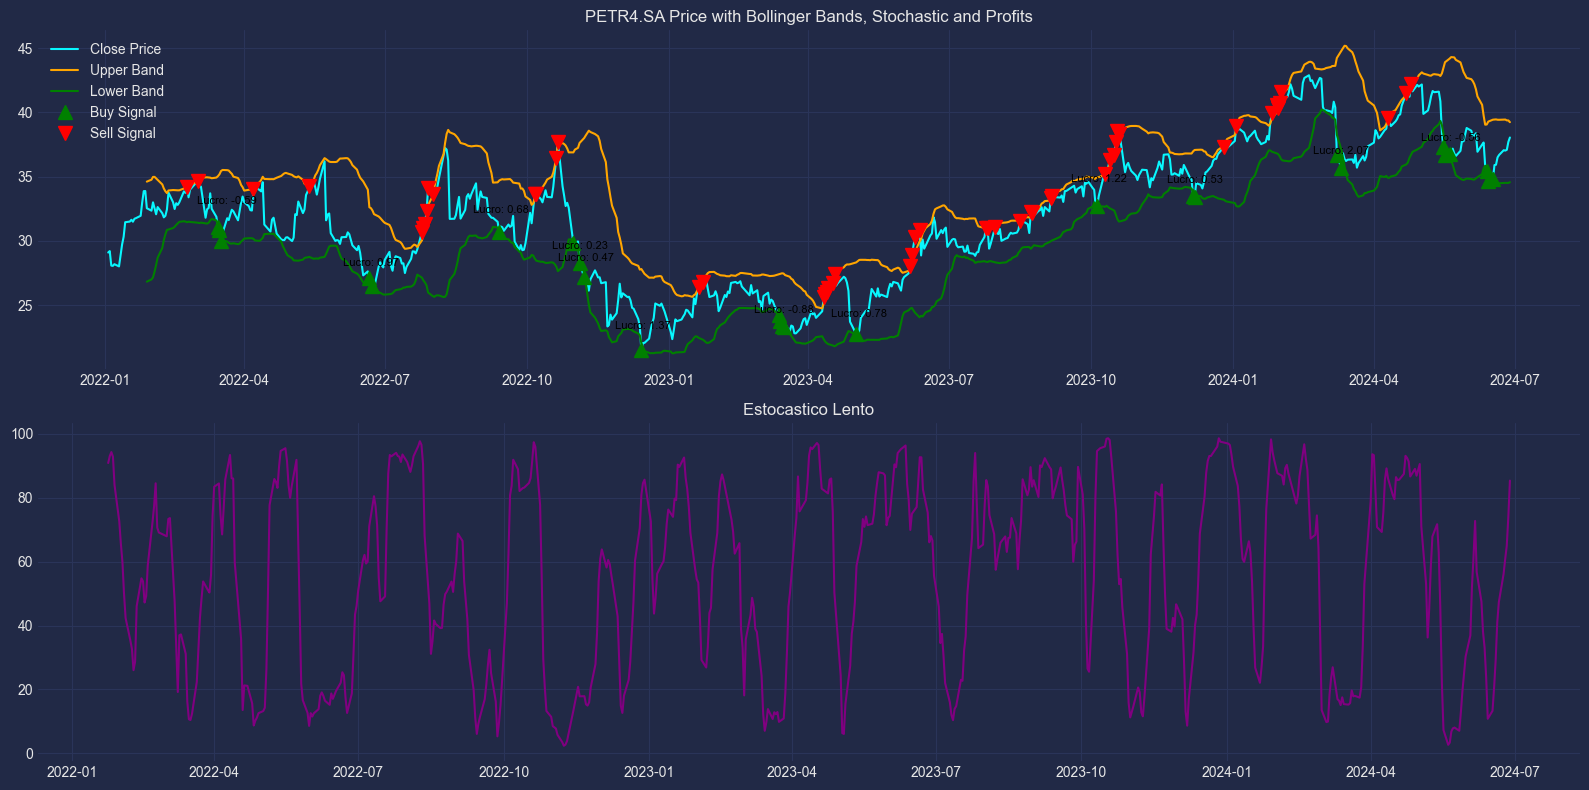

Lucro Total: 6.29


In [52]:
# Plotando os resultados
plt.style.use("cyberpunk")
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.plot(data['Close'], label='Close Price')
plt.plot(data['Upper Band'], label='Upper Band', color='orange')
plt.plot(data['Lower Band'], label='Lower Band', color='green')

# Plotando os sinais de compra/venda
plt.plot(data[data['Buy_Signal'] == 1].index, data['Close'][data['Buy_Signal'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(data[data['Sell_Signal'] == 1].index, data['Close'][data['Sell_Signal'] == 1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

# Plotando os lucros
for venda in data_venda:
    if venda in data.index:
        plt.annotate(f'Lucro: {data.loc[venda, "Profit"]:.2f}', (venda, data.loc[venda, 'Close']),
                     textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='black')

plt.title(f'{ativos[0]} Price with Bollinger Bands, Stochastic and Profits')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data['%D'], label='Estocastico', color='purple')
plt.title("Estocastico Lento")

plt.tight_layout()
plt.show()

# Mostrar o lucro total
total_profit = data['Profit'].sum()
print(f"Lucro Total: {total_profit:.2f}")